<a href="https://colab.research.google.com/github/boradj/SkimLit/blob/main/SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SkimLit

###Gpu acess check

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c0d9a18c-6041-fbc8-317e-3afcfd257236)


### Downloading data

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 10.25 MiB/s, done.


In [ ]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
#visualizing data of PubMed_20k
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


*`dev is for validation set`

In [ ]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# taking all file in our target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

### Preprocess data

In [ ]:
### now visualizing data
def get_lines(filenames):
  """
  Reads filename (a text filename) and returns the lines of text as a list.
  
  Args:
    filename: a string containing the target filepath.
  
  Returns:
    A list of strings with one string per line from the target filename.
  
  """
  with open(filenames, "r") as f:
    return f.readlines() # Reads the remaining lines from file and returns them as a list.
    



In [ ]:
train_lines = get_lines(data_dir +"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

* list of dict is best form in this type of problem

### Function to seperate data-set, so it can be visualized easily


In [ ]:
def preprocess_text_with_line_numbers(filename):
  """

    Returns a list of dictionaries of in organize format for previous visualized dataset.

    Takes filename, read it information and sorts through according to our requirement.

    Extracted content: Target Label
                       Text of sentenses,
                       Number of sentenses,
                       Senstense index.

  """

  input_lines = get_lines(filename) # getting information in form of list.
  abstract_lines = "" # for seperating abstact.
  abstract_samples = [] # empty list of abstracts.

  # Skim through each line in target file.

  for line in input_lines:
    if line.startswith("###"): # To check, is it new abstract? than get ID.
      abstract_id = line
      abstract_lines = "" # Reset abstract_lines if condition meet.
    elif line.isspace(): # Check if line is new line.
      abstract_line_split = abstract_lines.splitlines() # split abstract into seperate lines.

      # Going through each line for individual abstract
      
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0] # split target label from text 
        line_data["text"] = target_text_split[1].lower() # getting text in form of lower case
        line_data["line_numer"] = abstract_line_number # number of line 
        line_data["total_lines"] = len(abstract_line_split) -1 # line starting from zero
        abstract_samples.append(line_data)
    
    else:
        abstract_lines += line
    
  return abstract_samples
        


         



### Getting data from file and preprocess it

In [ ]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 420 ms, sys: 94.2 ms, total: 514 ms
Wall time: 514 ms


In [ ]:
# inspecting dectionary, how is it structured ?
# train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_numer': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_numer': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_numer': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_numer': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontario an

In [ ]:
# Creating Dataframe for good visualisation

import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

In [ ]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

### Get lists of sentences

In [ ]:
# Converting abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)


In [ ]:
# Visualising data
train_sentences[:10]

### Make numeric labels

In [ ]:
# One hot encode

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=True) # non-sparse matrix 
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy())

# Visualising one hot enoder

train_labels_one_hot

In [ ]:
# One hot encode

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # non-sparse matrix 
                                             # Not compatible with tensorflow(keep False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1, 1))

# Visualising one hot enoder

train_labels_one_hot

In [ ]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

### Label encode labels

In [ ]:
# Extract labels ("target" columns) and encode them into integers

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_label_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Visualising labels
train_labels_encoded


In [ ]:
# Geting classes names which is taken as reference for this
num_classes = len(lable_encoder.classes_)
class_names =  label_encoder.classes_
print(num_classes, class_names)

## Experimenting with different model

### Model 0: Getting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer # turn our text in to numbers
from sklearn.naive_bayes import MultinomialNB # model
from sklearn.pipeline import Pipeline

# Create a pipeline
# it take different steps in form of tuple
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, 
            y=train_labels_encoded);

In [ ]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

In [ ]:
## Downloading helper function

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


In [ ]:
# Import helper function

from helper_functions import calculate_results

In [ ]:
# results

baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

### Preparing our data for deep sequence models

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# Checking average length of sentenses
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

26.338269273494777

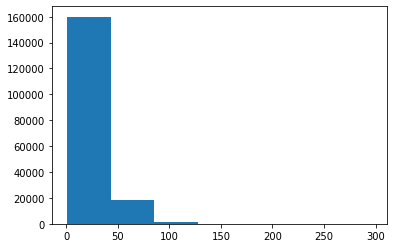

In [ ]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [ ]:
# length of sequence, so it can cover more 90 percent

output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
# Maximum sentence length in the training set

max(sent_lens)

296

### Create text vectorizer

In [ ]:
# number of words in our vocabulary (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)

max_tokens = 68000

In [ ]:
# Text vectorizer

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55) # desired output length of vectorized sequences

In [ ]:
# Applying text vectorizer on training dataset

text_vectorizer.adapt(train_sentences)

In [ ]:
# Testing Text Vectorizer

import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
http://www.clinicaltrials.gov .

Length of text: 2

Vectorized text:
[[2243    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# Words in our training vocabulary

rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer

text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

### Create custom text embedding

In [ ]:
# Creating token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # Length of dataset vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding") 

# Showing example embedding

print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
http://www.clinicaltrials.gov .

Sentence after vectorization (before embedding):
[[2243    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[ 0.0105269   0.04210378  0.04194726 ...  0.0111946   0.02379807
   -0.0433928 ]
  [-0.02391002  0.04098249 -0.0333933  ...  0.01311035 -0.02968328
   -0.04724472]
  [-0.02391002  0.04098249 -0.0333933  ...  0.01311035 -0.02968328
   -0.04724472]
  ...
  [-0.02391002  0.04098249 -0.0333933  ...  0.01311035 -0.02968328
   -0.04724472]
  [-0.02391002  0.04098249 -0.0333933  ...  0.01311035 -0.02968328
   -0.04724472]
  [-0.02391002  0.04098249 -0.0333933  ...  0.01311035 -0.02968328
   -0.04724472]]]

Embedded sentence shape: (1, 55, 128)


In [ ]:
# Turn our data into TensorFlow Datasets

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched batches

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

### Model 1: Conv1D with token embeddings

In [ ]:
# Create 1D convolutional sequence model

inputs = layers.Input(shape=(1,), dtype=tf.string) # One sequence at a time
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile

model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Getting summary of Conv1D model

model_1.summary()

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 36s 8ms/step - loss: 0.9290 - accuracy: 0.6280 - val_loss: 0.6956 - val_accuracy: 0.7350
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6647 - accuracy: 0.7528 - val_loss: 0.6353 - val_accuracy: 0.7666
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6231 - accuracy: 0.7742 - val_loss: 0.6017 - val_accuracy: 0.7839


In [ ]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6040 - accuracy: 0.7845


[0.6039669513702393, 0.784489631652832]

In [ ]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[4.65810180e-01, 1.68030873e-01, 9.11973268e-02, 2.48495579e-01,
        2.64659580e-02],
       [3.85841161e-01, 3.26967925e-01, 1.09655075e-02, 2.69699097e-01,
        6.52625971e-03],
       [1.50063470e-01, 1.18270982e-02, 1.80714345e-03, 8.36278021e-01,
        2.42987626e-05],
       ...,
       [5.72754607e-06, 8.22585251e-04, 5.39675879e-04, 1.08408301e-06,
        9.98630941e-01],
       [5.39277196e-02, 4.82838809e-01, 9.59893093e-02, 5.87528460e-02,
        3.08491379e-01],
       [2.05477521e-01, 5.33861935e-01, 5.17199412e-02, 8.40113238e-02,
        1.24929301e-01]], dtype=float32)

In [ ]:
# Getting classes 
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculating results for model 1
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.44896067787634,
 'f1': 0.7822985872046467,
 'precision': 0.7814941086130403,
 'recall': 0.7844896067787634}

## Model 2: Feature extraction with pretrained token embeddings

In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
data were collected from @,@ @th - and @th-grade students in these communities using anonymous cross-sectional surveys in @ and @ and analyzed in @ .

Sentence after embedding:
[-0.03330918  0.06432742 -0.04426299 -0.03340627  0.01580565  0.04260787
  0.05223562  0.02998829 -0.09009711  0.01004721 -0.01640431 -0.02970598
  0.06300306  0.0500071  -0.02137795  0.01532154  0.00676913  0.04174187
  0.00070422 -0.08601078  0.02839869  0.07599191 -0.05524107 -0.00862489
 -0.04704431  0.05998407 -0.00028414 -0.01645767  0.05340267 -0.06473802] (truncated output)...

Length of sentence embedding:
512


### Building and fitting an NLP feature extraction model from TensorFlow Hub

In [ ]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a summary of the model
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 9s 12ms/step - loss: 0.9150 - accuracy: 0.6498 - val_loss: 0.7939 - val_accuracy: 0.6895
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7681 - accuracy: 0.7022 - val_loss: 0.7523 - val_accuracy: 0.7058
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7509 - accuracy: 0.7127 - val_loss: 0.7367 - val_accuracy: 0.7138


In [ ]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 10ms/step - loss: 0.7403 - accuracy: 0.7143


[0.7403141856193542, 0.7142525911331177]

In [ ]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.3034002e-01, 3.5648319e-01, 2.3842952e-03, 2.0301045e-01,
        7.7820425e-03],
       [3.5814181e-01, 4.8381555e-01, 3.4082821e-03, 1.5132000e-01,
        3.3143654e-03],
       [2.2659931e-01, 1.5397042e-01, 2.1248475e-02, 5.6063354e-01,
        3.7548285e-02],
       ...,
       [1.7298853e-03, 5.6997794e-03, 5.2002735e-02, 8.3732005e-04,
        9.3973035e-01],
       [3.5631014e-03, 4.8854645e-02, 1.8445115e-01, 1.2047966e-03,
        7.6192635e-01],
       [1.7391451e-01, 3.0626863e-01, 4.5657125e-01, 5.7948320e-03,
        5.7450745e-02]], dtype=float32)

In [ ]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.42526148550245,
 'f1': 0.7114550329161863,
 'precision': 0.7148806814011546,
 'recall': 0.7142526148550244}

## Model 3: Conv1D with character embeddings


### Creating a character-level tokenizer

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

'd a t a   w e r e   c o l l e c t e d   f r o m   @ , @   @ t h   -   a n d   @ t h - g r a d e   s t u d e n t s   i n   t h e s e   c o m m u n i t i e s   u s i n g   a n o n y m o u s   c r o s s - s e c t i o n a l   s u r v e y s   i n   @   a n d   @   a n d   a n a l y z e d   i n   @   .'

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

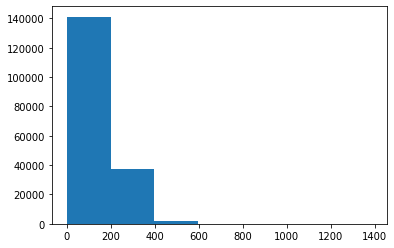

In [ ]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
a   p e r s i s t e n t   q u e s t i o n   i s   w h e t h e r   p a r a p r o f e s s i o n a l   h o m e   v i s i t o r s   m i g h t   p r o d u c e   c o m p a r a b l e   e f f e c t s   .

Length of chars: 86

Vectorized chars:
[[ 5 14  2  8  9  4  9  3  2  6  3 26 16  2  9  3  4  7  6  4  9 20 13  2
   3 13  2  8 14  5  8  5 14  8  7 17  2  9  9  4  7  6  5 12 13  7 15  2
  21  4  9  4  3  7  8  9 15  4 18 13  3 14  8  7 10 16 11  2 11  7 15 14
   5  8  5 22 12  2  2 17 17  2 11  3  9  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0 

### Creating a character-level embedding

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
a   p e r s i s t e n t   q u e s t i o n   i s   w h e t h e r   p a r a p r o f e s s i o n a l   h o m e   v i s i t o r s   m i g h t   p r o d u c e   c o m p a r a b l e   e f f e c t s   .

Embedded chars (after vectorization and embedding):
[[[-0.01923175 -0.01720572  0.04752548 ... -0.00952251 -0.03900822
   -0.01606651]
  [ 0.02746468 -0.0157405  -0.03408597 ...  0.00957409 -0.04426242
    0.02547267]
  [-0.00342412  0.04883511 -0.02929975 ... -0.04722989  0.04408958
    0.02328778]
  ...
  [-0.02053725  0.04947415 -0.03963646 ...  0.04780323  0.00831659
   -0.00033282]
  [-0.02053725  0.04947415 -0.03963646 ...  0.04780323  0.00831659
   -0.00033282]
  [-0.02053725  0.04947415 -0.03963646 ...  0.04780323  0.00831659
   -0.00033282]]]

Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings

In [ ]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Check the summary of conv1d_char_model
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           1750      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 10,139
Trainable params: 10,139
Non-trainable params: 0
_________________________________

In [ ]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 5ms/step - loss: 1.2697 - accuracy: 0.4940 - val_loss: 1.0555 - val_accuracy: 0.5864
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0124 - accuracy: 0.5996 - val_loss: 0.9542 - val_accuracy: 0.6267
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9228 - accuracy: 0.6410 - val_loss: 0.8712 - val_accuracy: 0.6722


In [ ]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.8873 - accuracy: 0.6588


[0.8873457908630371, 0.6587779521942139]

In [ ]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.14757556, 0.40572175, 0.06463172, 0.33147973, 0.05059117],
       [0.33927342, 0.25103244, 0.01815611, 0.35482603, 0.03671199],
       [0.15584646, 0.11993653, 0.10841523, 0.5846738 , 0.03112798],
       ...,
       [0.02389161, 0.04591153, 0.07370146, 0.01870138, 0.83779407],
       [0.01393123, 0.10044182, 0.55801105, 0.05441127, 0.2732046 ],
       [0.28039306, 0.582124  , 0.04549843, 0.04313584, 0.04884864]],
      dtype=float32)

In [ ]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 3, 3, ..., 4, 2, 1])>

In [ ]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 65.87779690189329,
 'f1': 0.6516863332082763,
 'precision': 0.6545009464773592,
 'recall': 0.6587779690189329}

### Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [ ]:
# Get summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________

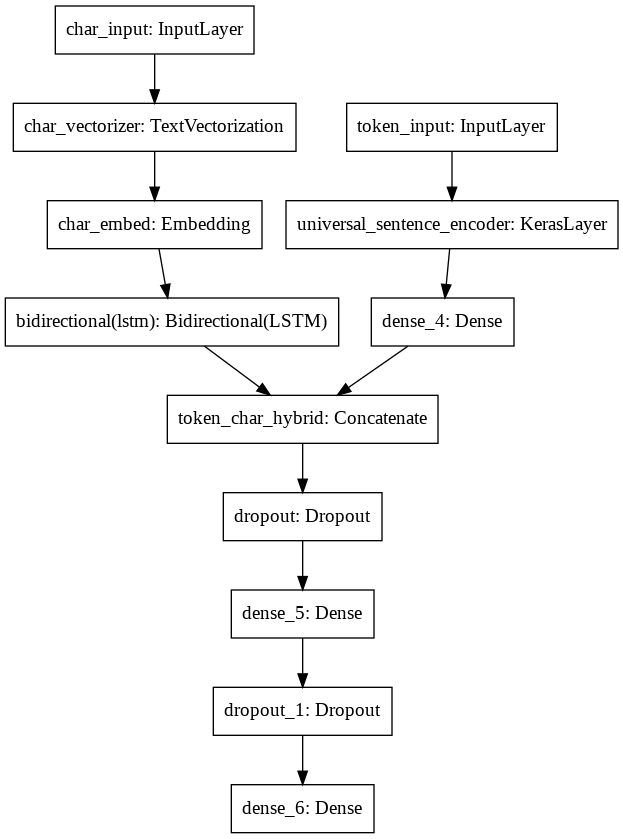

In [ ]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])